In [1]:
import numpy as np
import sys
import matplotlib
sys.path.append('../qslam')

from visualiserisk import *
from qslamdesignparams import GRIDDICT

# Parameter Regimes

The set of parameters are given in the dictionary format, LOOPS_DICT, and used for analysis via ParamUpdater. 

In [2]:
# Choose defaults to match floor case (heights didn't work)
TRUTHKWARGS = {}

BARRIER_FLOOR = 0.25*np.pi
BARRIER_HEIGHT = 0.75*np.pi
FLOOR_RATIO = 0.4 # matches floor case

TRUTHKWARGS["OneStepdheight"] = {"low": BARRIER_FLOOR, 
                                 "high": BARRIER_HEIGHT} 
TRUTHKWARGS["OneStepdfloorarea"] = FLOOR_RATIO 

prefix_list = ['2019_Jun_1D', '2019_Jun_2D', '2019_Jun_2D_Gssn'] #2019_Jun_1D
PATHDICT['pdir'] = './data_v3'
loadpath = ''

In [3]:
# ------------------------------------------------------------------------------
# TURN OFF PARAMETER SCANS
# ------------------------------------------------------------------------------

idx_prevar = 0 
# Fix truth configurations
meta_truth_floor_scan = [FLOOR_RATIO] # [0.2, 0.4, 0.6, 0.8, 1.0]
lowscan = [BARRIER_FLOOR] # np.asarray([0.2]*5)*np.pi
highscan = [BARRIER_HEIGHT] # np.asarray([0.2, 0.4, 0.6, 0.8, 1.0])*np.pi
truth_step_scan = zip(lowscan, highscan)


idx_noise_var = 0 
# Fix to noiseless case
noiseclasses = ['noiseless'] 
noisestrengths = [0.0]
meta_noisevar_scan = zip(noiseclasses, noisestrengths)

# Fix msmt scan - and turn it off!
idx_var_dict =0 # only takes lambda scan
msmt_per_qubit_scan = [1] # [1, 2, 4, 5, 6, 8, 10, 15, 20, 25, 50]

# ------------------------------------------------------------------------------

# ------------------------------------------------------------------------------
# NEW PARAMETER SCANS
# ------------------------------------------------------------------------------

meta_max_iter_scan = [ 5, 10, 15, 20, 25, 50, 75, 100, 125, 250]

lambda_databse = np.load('./lambda_pairs.npz')
lambda1 = list(lambda_databse['lambda_1']) # [0.99, 0.956, 0.922, 0.888, 0.854, 0.820, 0.786, 0.752, 0.718, 0.684, 0.65]
lambda2 = list(lambda_databse['lambda_2']) # [0.977, 0.9752, 0.9734, 0.9716, 0.9698, 0.968, 0.9662, 0.9644, 0.9626, 0.9608, 0.959]
lambda_scan = zip(lambda1, lambda2)

LOOPS_DICT = {"meta_truth_floor_scan": meta_truth_floor_scan,
              "meta_max_iter_scan":meta_max_iter_scan, 
              "meta_noisevar_scan": meta_noisevar_scan,
              "truth_step_scan": truth_step_scan,
              "lambda_scan":lambda_scan,
              "msmt_per_qubit_scan": msmt_per_qubit_scan}

ParamUpdater = DataCube(LOOPS_DICT)


#### Get data filenames

In [4]:
weightratioslist = []
msmtperqubitlist = []

for prefix in prefix_list:

    regime_ID = prefix + '_n_' + str(idx_noise_var) +'_vset_' + str(idx_var_dict)
    datafile = './data_v3/'+'RISK_' + regime_ID +'.npz'

    if idx_var_dict == 0:
        weightratioslist.append(datafile) 
#     elif idx_var_dict ==1 :
#         msmtperqubitlist.append(datafile)

# Data variables
max_msmtvar = len(ParamUpdater.meta_max_iter_scan)
max_var = max(len(ParamUpdater.lambda_scan), len(ParamUpdater.msmt_per_qubit_scan))

# Data Analysis

In [5]:
THRESHOLD = 0.1
max_lambda_var_ =50
max_cases = len(weightratioslist)
max_msmt_var = len(ParamUpdater.meta_max_iter_scan)
metrictype_ = 3 # SSIM
metrictypename = 'SSIM'
# metrictype_ = 2 # RMS
# metrictypename = 'RMS'
max_var = len(ParamUpdater.lambda_scan)
idx_prevar=0


def get_loss_data(filename, idx_prevar, idx_msmt_var, max_lambda_var=50, metrictype=3):
    
    full_data_matrix = np.load(filename)["full_data_matrix"]    
    qslamdata = full_data_matrix[idx_prevar, idx_msmt_var, : max_lambda_var, 0, metrictype] #qslam is the first index
    naivedata = full_data_matrix[idx_prevar, idx_msmt_var, : max_lambda_var, 1, metrictype]
    index_array = np.argsort(qslamdata)
    
    return qslamdata, index_array, naivedata


def extract_optimal_cases(max_cases,max_msmt_var, max_lambda_var=50, metrictype=3):
    
    
    optimal_matrix = np.zeros((max_cases, max_msmt_var, 3))
    naive_matrix = np.zeros((max_cases, max_msmt_var, 2))
    optimal_cases = np.zeros((max_cases, max_msmt_var, max_lambda_var))
    
    for idx_msmt_var in range(max_msmt_var):
        
        for idx_truth in range(max_cases):
            
            filename = weightratioslist[idx_truth]
            a, index_array, naive = get_loss_data(filename, idx_prevar, idx_msmt_var, 
                                                  max_lambda_var=max_lambda_var,
                                                  metrictype=metrictype)


            optimal_matrix[idx_truth, idx_msmt_var, 0] = a[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 1] = lambda1[index_array[0]]
            optimal_matrix[idx_truth, idx_msmt_var, 2] = lambda2[index_array[0]]

            naive_matrix[idx_truth, idx_msmt_var, 0] = np.mean(naive)
            naive_matrix[idx_truth, idx_msmt_var, 1] = np.std(naive)
            
            truncate = len(index_array)           
            optimal_cases[idx_truth, idx_msmt_var, :truncate] = index_array
    
    return optimal_matrix, naive_matrix, optimal_cases

In [6]:
oneD_GRIDDICT= {}
for idx_posy in range(25):

    if idx_posy < 9 :
        oneD_GRIDDICT["QUBIT_0" + str(idx_posy + 1)] = ( float(idx_posy), 0.0)

    if idx_posy >= 9 :
        oneD_GRIDDICT["QUBIT_" + str(idx_posy + 1)] = (float(idx_posy), 0.0)



# Single Run Maps

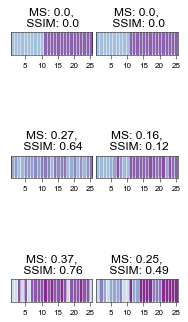

('run chosen', 24)


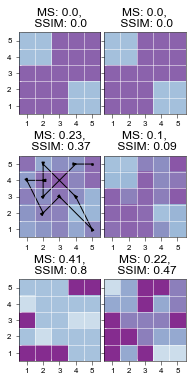

('run chosen', 30)


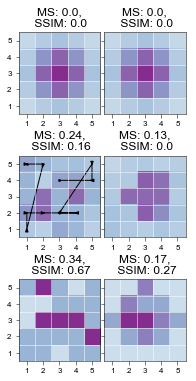

('run chosen', 20)


In [11]:
savetopath = ''
loadpath = ''
qax = qPlotter()
PICK = [24, 30, 20] # 30 # np.random.randint(low=0, high=50)

optimal_matrix, naive_matrix, optimal_cases = extract_optimal_cases(max_cases, max_msmt_var, 
                                                                    max_lambda_var=max_lambda_var_,
                                                                    metrictype=metrictype_)

gslayout = gs(3, 9, top = 0.95, bottom =0.05, left = 0.05, right = 0.95, wspace = 0.05, hspace = 0.12)

pick_msmt_regimes = [1, 6]

idx_pick_key=0
for idx_truth in range(len(weightratioslist)):
    
    fig = plt.figure(figsize=(cm2inch(30),cm2inch(14)))
    
    if idx_truth == 0:
        GRIDDICT_IDX = oneD_GRIDDICT
        LINFLAG = True
    elif idx_truth != 0:
        GRIDDICT_IDX = GRIDDICT
        LINFLAG = False

    for idx_msmt_regime in range(len(pick_msmt_regimes)):
        
        idx_msmt_var = pick_msmt_regimes[idx_msmt_regime] # set msmt regime
    
        filename = weightratioslist[idx_truth]
        index_array = get_loss_data(filename, idx_prevar, idx_msmt_var)[1]
        
        idx_var = index_array[0] # pick optimal lambda for the msmt regime
        
        regime_ID = prefix_list[idx_truth] + '_n_' + str(idx_noise_var) +'_vset_' + str(idx_var_dict)
        testcase_ID = regime_ID + '_t_' + str(idx_prevar) + '_m_' + str(idx_msmt_var)
        unique_ID = loadpath + testcase_ID + '_v_' + str(idx_var)
        PATHDICT["fle"] = unique_ID
        qslamdata = np.load(path_to_file(PATHDICT, flag='q'))
        naivedata = np.load(path_to_file(PATHDICT, flag='n'))
                
        dataobjs = [qslamdata]*2 + [naivedata]
        dataviews = ['truth', 'pred_f', 'pred_f']
        
        ######
        # SCORE CALCS
        ######
        q_truth = qslamdata['macro_true_fstate'][0, PICK[idx_pick_key], :]
        n_truth = naivedata['macro_true_fstate'][0, PICK[idx_pick_key], :]
        n_pred = naivedata['macro_predictions'][0, PICK[idx_pick_key], :]
        q_pred = qslamdata['macro_predictions'][0, PICK[idx_pick_key], :]

        q_rms = np.sqrt(np.mean((q_truth - q_pred)**2)) / np.pi
        n_rms = np.sqrt(np.mean((n_truth - n_pred)**2)) / np.pi
        q_ssim = Metric.score_ssim(q_pred, q_truth)
        n_ssim = Metric.score_ssim(n_pred, n_truth)
        
        rms_list = [0.0, np.round(q_rms, 2), np.round(n_rms, 2)]
        ssim_list = [0.0, np.round(q_ssim, 2), np.round(n_ssim, 2)]
        

        for idx_key in range(3):

            ax = 0.
            ax = fig.add_subplot(gslayout[idx_key, idx_msmt_regime])
            
            ax.set_title('MS: %s,\n SSIM: %s'%(rms_list[idx_key], ssim_list[idx_key]), fontsize=12)
            viewtype = dataviews[idx_key]
            
            if viewtype != 'path':
                if viewtype != 'pred_r':
                    ax, cax = qax.show_map(ax, dataobjs[idx_key], viewtype, pickone=PICK[idx_pick_key], linear=LINFLAG)
                    if idx_key == 1 and idx_msmt_regime == 0 and idx_truth > 0:
                        
                        ax = qax.show_control_path(ax, dataobjs[idx_key], GRIDDICT_IDX, pickone=PICK[idx_pick_key], 
                                                   linear=LINFLAG)
                        
                        
#                     if idx_key == 1:
                        
#                         ax1 = fig.add_subplot(gslayout[idx_key, idx_msmt_regime**2 + 2] )
                        
#                         ax1 = qax.show_control_path(ax1, dataobjs[idx_key], GRIDDICT_IDX, pickone=PICK[idx_pick_key], 
#                                                    linear=LINFLAG)
#                         ax1.get_yaxis().set_visible(False)
#                         ax1.get_xaxis().set_visible(False)
#                         for edge, spine in ax1.spines.items():
#                             spine.set_visible(False)
                        

            if viewtype == 'path':
                ax = qax.show_control_path(ax, dataobjs[idx_key], GRIDDICT_IDX, pickone=PICK[idx_pick_key])
                
            if idx_truth ==0:
                ax.set_aspect(7)
                
            # TURN OFF AXIS LABELS
            if idx_msmt_regime > 0:
                ax.get_yaxis().set_ticklabels([])
            #if idx_key == 1:
                # ax.get_xaxis().set_ticklabels([])
            
            
    # plt.colorbar(cax, ticks=[0.0, np.pi], format='%0.2f', orientation='horizontal')
    plt.savefig('../paperfigs/'+metrictypename+str(idx_truth)+'_rms_demo_v3.svg', format='svg', dpi=800)
    plt.show()
    
    print('run chosen', PICK[idx_pick_key])
    idx_pick_key += 1